In [1]:
import torch
import torch.nn as nn
import torchvision

In [30]:
from torch.utils.data import Dataset, DataLoader

**Pytorch Mechanics:**
- note that only tensors of floating point and complex dtype can require gradients. In the following code we will generate tensor objects of type float32

In [2]:
a = torch.tensor(3.14, requires_grad=True)
print(a)

tensor(3.1400, requires_grad=True)


In [3]:
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)

tensor([1., 2., 3.], requires_grad=True)


=> requires_grad - set to false by default. But can be efficiently set to true by running requires_grad_().
=> NN models, initializing model parameters with random weights necessary to break the symmetry during backpropagation - otherwise, a multilayer NN would be no more useful than a single-layer NN like logistic regression. 
=> Initialization schemes can be found under: torch.nn.init.*

In [5]:
# e.g. using glorot initialization on a tensor:
torch.manual_seed(1)

w = torch.empty(2,3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


Automatic differentiation example with a simple linear regression calculation:

In [6]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])

z = torch.add(torch.mul(w,x),b)

In [7]:
loss = (y-z).pow(2).sum()

In [8]:
loss.backward()

In [9]:
print('dL/dw: ',w.grad)
print('dL/db: ',b.grad)

dL/dw:  tensor(-0.5600)
dL/db:  tensor(-0.4000)


Computing the value z is a forward pass in a NN. We used the backward method on the loss tensor to compute dLoss/dw and dLoss/db

Another approach for building models is based on nn.Sequential:
- with nn.sequential, the layers stored inside the model are connected in a cascaded way. e.g below, we build a model with two densely connected layers

In [10]:
model = nn.Sequential(
    nn.Linear(4,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In the following code example, we will configure the first fully connected layer by specifying the initial value distribution for the weight. Then, we will configure the second fully connected layer by computing the L1 penalty term for the weight matrix.

In [18]:
# initializing weights for layers in a sequential model
nn.init.xavier_uniform_(model[0].weight)

# l2 regularization can be added by using the weight decay optimizer parameter, except for adam optimizer where you'd have
# to use the adamw optimizer instead

# applying l1 regularization is by adding the l1 penalty term to the loss tensor:
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

add this l1_penalty to the loss when looking at l1 regularization.

Here, we initialized the weight of the first linear layer with xavier initialization, and we computed the l1 norm of the weight of the second linear layer. 

**Choosing a loss function:**
- Task dependent 

**Solving the classic XOR classification problem:**
- The XOR classification problem is a classic problem for analyzing the capacity of a model with regard to capturing the nonlinear decision boundary between classes. We use a toy dataset of 200 training examples with 2 features (xo,x1) drawn from a uniform distribution between [-1,1). Then, we assign the ground truth label for training example i, according to the xor rule. We use half of the data (100 training examples) for training and the remaining half for validation. 

In [19]:
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(1)
np.random.seed(1)

In [20]:
x = np.random.uniform(low=-1, high=1, size=(200,2))
y = np.ones(len(x))
y[x[:,0]*x[:,1] < 0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train,:], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:,:], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

Creating a dataset and dataloader for the data:

In [50]:
class XORDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = y
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.x.shape[0]

In [51]:
x_train.shape, y_train.shape

(torch.Size([100, 2]), torch.Size([100]))

In [52]:
train_dataset = XORDataset(x_train,y_train)
train_dl = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [53]:
for m,n in train_dl:
    print(m.shape,n.shape)
    break

torch.Size([2, 2]) torch.Size([2])


In [54]:
valid_dataset = XORDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_dataset, batch_size=2, shuffle=False)

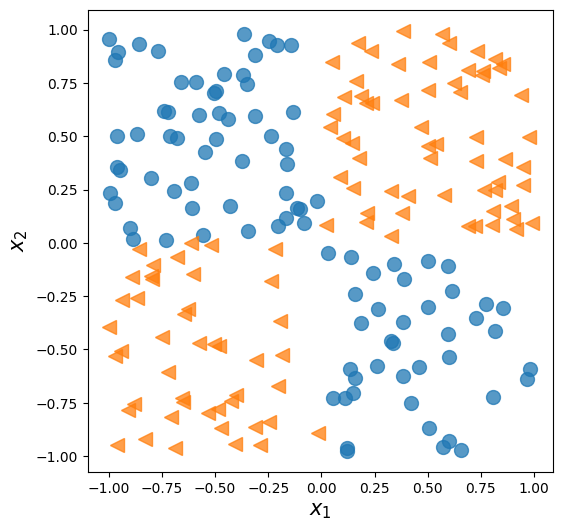

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.plot(x[y==0,0],x[y==0,1],'o',alpha=0.75,markersize=10)
ax.plot(x[y==1,0],x[y==1,1],'<',alpha=0.75,markersize=10)
plt.xlabel(r'$x_1$',size=15)
plt.ylabel(r'$x_2$',size=15)
plt.show()

Now need to build a model that can learn the requisite decision function for the above data. As a general rule of thumb, the more layers we have, and the more neurons we have in each layer, the larger the capacity of the model will be. While having more parameters means the network can fit more complex functions, larger models are usually harder to train (and prone to overfitting). In practice, it is always a good idea to start with a simple model as a baseline - for example a single-layer NN like logistic regression.

In [145]:
model = nn.Sequential(
    nn.Linear(2,1),
    nn.Sigmoid()
)

In [146]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Initializing using the glorot initialization since the activation function is sigmoid.

In [147]:
nn.init.xavier_normal_(model[0].weight)

Parameter containing:
tensor([[-0.0923,  0.5990]], requires_grad=True)

After defining the model - lets now initiliaze the cross entropy loss fn and SGD optimizer

In [148]:
loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [149]:
torch.manual_seed(1)
num_epochs = 200

In [150]:
running_train_loss = []
running_train_acc = []
validation_loss = []
validation_accuracy = []

In [151]:
tl,ta,vl,va = [],[],[],[]

In [152]:
for epoch in range(num_epochs):
    for i, (x_tr, y_tr) in enumerate(train_dl):
        # forward pass
        outputs = model(x_tr)[:,0]
        # compute the loss
        loss = loss_fn(outputs, y_tr)
        #print(loss.item())
        # compute the gradients
        loss.backward()
        # optimize
        optimizer.step()
        running_train_loss.append(loss.item())
        
        running_train_acc.append(((outputs > 0.5).float() == y_tr).sum().item()/y_tr.shape[0])

     # set the model to evaluation mode for validation
    
    with torch.no_grad():
        for i,(x_va,y_va) in enumerate(valid_dl):
            valid_outputs = model(x_va)[:,0]
            valid_loss = loss_fn(valid_outputs,y_va)
            validation_loss.append(valid_loss.item())

            validation_accuracy.append(((valid_outputs > 0.5).float() == y_va).sum().item()/y_va.shape[0])

    optimizer.zero_grad()
    
    print(f'Epoch: {epoch+1}, train_loss: {sum(running_train_loss)/len(running_train_loss):.4f}, val_loss: {sum(validation_loss)/len(validation_loss):.4f}, train_acc: {sum(running_train_acc)/len(running_train_acc):.4f}, valid_acc: {sum(validation_accuracy)/len(validation_accuracy):.4f}')
    tl.append(sum(running_train_loss)/len(running_train_loss))
    vl.append(sum(validation_loss)/len(validation_loss))
    ta.append(sum(running_train_acc)/len(running_train_acc))
    va.append(sum(validation_accuracy)/len(validation_accuracy))

Epoch: 1, train_loss: 0.7238, val_loss: 0.7082, train_acc: 0.5200, valid_acc: 0.5400
Epoch: 2, train_loss: 0.7203, val_loss: 0.7049, train_acc: 0.5100, valid_acc: 0.5350
Epoch: 3, train_loss: 0.7175, val_loss: 0.7018, train_acc: 0.4933, valid_acc: 0.5267
Epoch: 4, train_loss: 0.7146, val_loss: 0.6997, train_acc: 0.4800, valid_acc: 0.5200
Epoch: 5, train_loss: 0.7128, val_loss: 0.6981, train_acc: 0.4720, valid_acc: 0.5120
Epoch: 6, train_loss: 0.7112, val_loss: 0.6964, train_acc: 0.4650, valid_acc: 0.5017
Epoch: 7, train_loss: 0.7095, val_loss: 0.6948, train_acc: 0.4543, valid_acc: 0.4929
Epoch: 8, train_loss: 0.7080, val_loss: 0.6937, train_acc: 0.4450, valid_acc: 0.4863
Epoch: 9, train_loss: 0.7067, val_loss: 0.6929, train_acc: 0.4378, valid_acc: 0.4811
Epoch: 10, train_loss: 0.7056, val_loss: 0.6920, train_acc: 0.4310, valid_acc: 0.4760
Epoch: 11, train_loss: 0.7045, val_loss: 0.6911, train_acc: 0.4245, valid_acc: 0.4700
Epoch: 12, train_loss: 0.7036, val_loss: 0.6903, train_acc: 0.4

In [154]:
tl,ta,vl,va = np.array(tl),np.array(ta),np.array(vl),np.array(va)

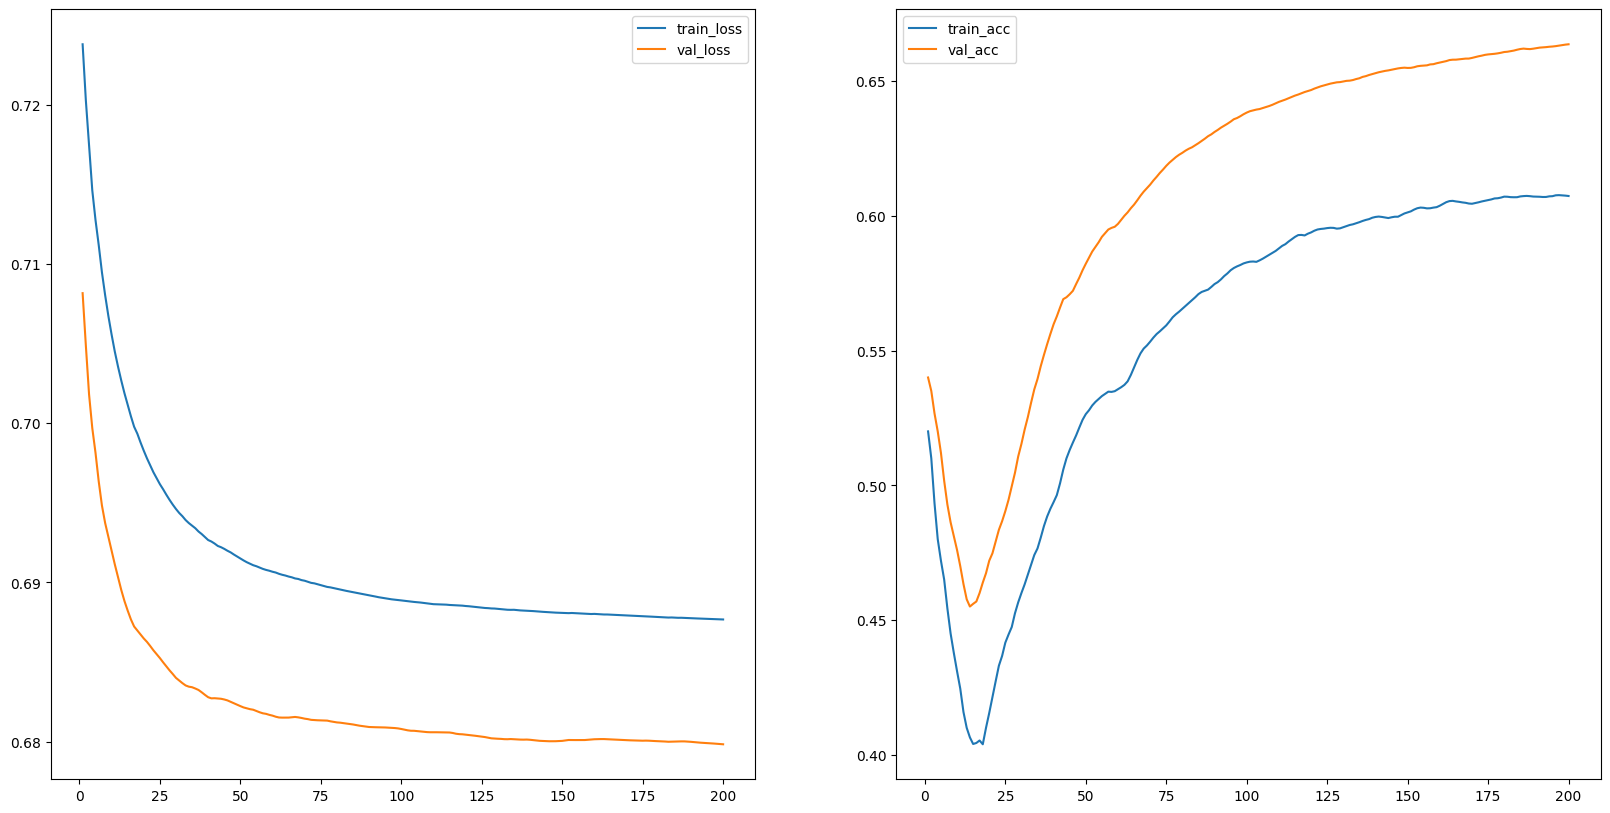

In [156]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(range(1,201),tl,label='train_loss')
ax[0].plot(range(1,201),vl,label='val_loss')
ax[1].plot(range(1,201),ta,label='train_acc')
ax[1].plot(range(1,201),va,label='val_acc')
ax[0].legend()
ax[1].legend()
plt.show()

The model with no hidden layer can only derive a linear decision boundary, which is unable to solve the XOR problem. As a consequence we can observe the loss terms being quite high and the accuracies being very low. 
- to derive a nonlinear decision boundary, we can add one or more hidden layers connected via non linear activation functions. The universal approximation theorem states that a feedforward NN with a single hidden layer and a relatively large number of hidden units can approximate arbitrary continuous functions relatively well. Thus, one approach for tackling the XOR problem more satisfactorily is to add a hidden layer and compare different numbers of hidden units well until we observe satisfactory results on the validation set. Adding more hidden units would correspond to increasing the width of a layer. Alternatlively, we can also add more hidden layers, which will make the model deeper. The advantage of makign anetwork deeper rather than wider is that fewer parameters are required to achieve a comparable model capacity.

In [157]:
model = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.Sigmoid()
)

In [158]:
nn.init.kaiming_normal_(model[0].weight)
nn.init.kaiming_normal_(model[2].weight)
nn.init.xavier_normal_(model[4].weight)

Parameter containing:
tensor([[-0.1985,  1.4347,  0.0380,  0.1238]], requires_grad=True)

In [159]:
loss_fn = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9,nesterov=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [160]:
torch.manual_seed(1)
num_epochs = 200

In [161]:
running_train_loss = []
running_train_acc = []
validation_loss = []
validation_accuracy = []

In [162]:
tl,ta,vl,va = [],[],[],[]

In [163]:
for epoch in range(num_epochs):
    for i, (x_tr, y_tr) in enumerate(train_dl):
        # forward pass
        outputs = model(x_tr)[:,0]
        # compute the loss
        loss = loss_fn(outputs, y_tr)
        #print(loss.item())
        # compute the gradients
        loss.backward()
        # optimize
        optimizer.step()
        running_train_loss.append(loss.item())
        
        running_train_acc.append(((outputs > 0.5).float() == y_tr).sum().item()/y_tr.shape[0])

     # set the model to evaluation mode for validation
    
    with torch.no_grad():
        for i,(x_va,y_va) in enumerate(valid_dl):
            valid_outputs = model(x_va)[:,0]
            valid_loss = loss_fn(valid_outputs,y_va)
            validation_loss.append(valid_loss.item())

            validation_accuracy.append(((valid_outputs > 0.5).float() == y_va).sum().item()/y_va.shape[0])

    optimizer.zero_grad()
    
    print(f'Epoch: {epoch+1}, train_loss: {sum(running_train_loss)/len(running_train_loss):.4f}, val_loss: {sum(validation_loss)/len(validation_loss):.4f}, train_acc: {sum(running_train_acc)/len(running_train_acc):.4f}, valid_acc: {sum(validation_accuracy)/len(validation_accuracy):.4f}')
    tl.append(sum(running_train_loss)/len(running_train_loss))
    vl.append(sum(validation_loss)/len(validation_loss))
    ta.append(sum(running_train_acc)/len(running_train_acc))
    va.append(sum(validation_accuracy)/len(validation_accuracy))

Epoch: 1, train_loss: 0.8603, val_loss: 0.7483, train_acc: 0.5000, valid_acc: 0.5500
Epoch: 2, train_loss: 0.8120, val_loss: 0.7253, train_acc: 0.5050, valid_acc: 0.5700
Epoch: 3, train_loss: 0.7809, val_loss: 0.7103, train_acc: 0.5167, valid_acc: 0.5767
Epoch: 4, train_loss: 0.7572, val_loss: 0.6960, train_acc: 0.5300, valid_acc: 0.5825
Epoch: 5, train_loss: 0.7383, val_loss: 0.6844, train_acc: 0.5260, valid_acc: 0.5640
Epoch: 6, train_loss: 0.7235, val_loss: 0.6750, train_acc: 0.5250, valid_acc: 0.5833
Epoch: 7, train_loss: 0.7104, val_loss: 0.6666, train_acc: 0.5443, valid_acc: 0.5971
Epoch: 8, train_loss: 0.6983, val_loss: 0.6588, train_acc: 0.5613, valid_acc: 0.6050
Epoch: 9, train_loss: 0.6876, val_loss: 0.6514, train_acc: 0.5733, valid_acc: 0.6111
Epoch: 10, train_loss: 0.6779, val_loss: 0.6444, train_acc: 0.5810, valid_acc: 0.6140
Epoch: 11, train_loss: 0.6688, val_loss: 0.6378, train_acc: 0.5873, valid_acc: 0.6164
Epoch: 12, train_loss: 0.6601, val_loss: 0.6313, train_acc: 0.5

In [164]:
tl,ta,vl,va = np.array(tl),np.array(ta),np.array(vl),np.array(va)

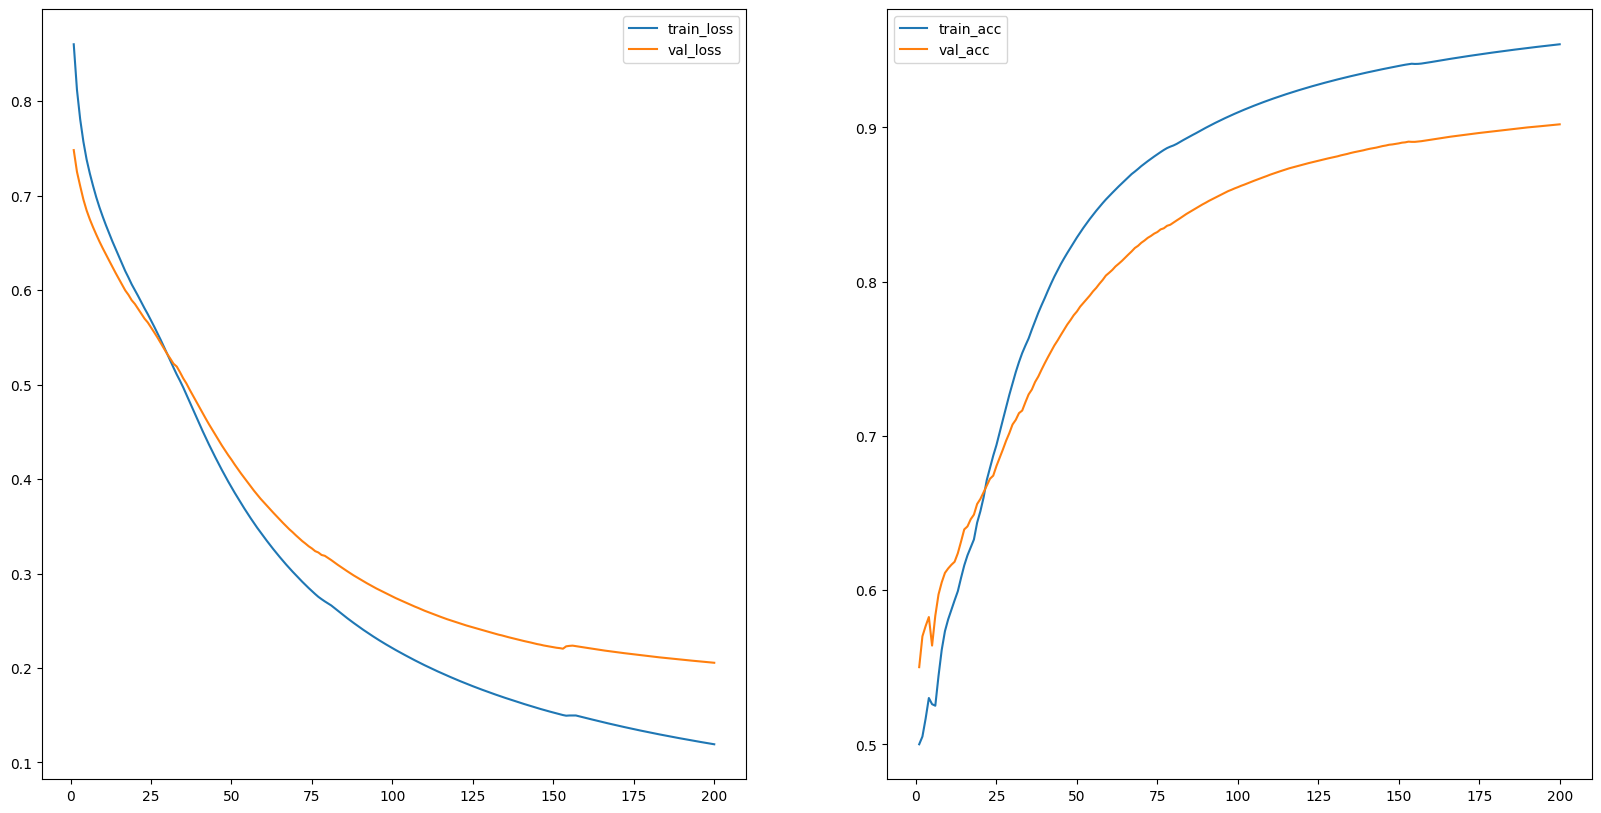

In [165]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(range(1,201),tl,label='train_loss')
ax[0].plot(range(1,201),vl,label='val_loss')
ax[1].plot(range(1,201),ta,label='train_acc')
ax[1].plot(range(1,201),va,label='val_acc')
ax[0].legend()
ax[1].legend()
plt.show()

Exercise:
- Doing it again but with 4 hidden layers:

In [205]:
model = nn.Sequential(
    nn.Linear(2,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,4),
    nn.ReLU(),
    nn.Linear(4,1),
    nn.Sigmoid()
)

In [206]:
# initialize the weights - weights for layers connected to relu activations: he/kaiming initialization, and weights for layers connected to sigmoid: xavier/glorot init
for i in range(0,7,2):
    nn.init.kaiming_normal_(model[i].weight)
else:
    nn.init.xavier_normal_(model[i+2].weight)

In [207]:
# define the loss and optimizer
loss_fn = nn.BCELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=1)

In [208]:
running_train_loss = []
running_train_acc = []
validation_loss = []
validation_accuracy = []

In [209]:
tl,ta,vl,va = [],[],[],[]

In [210]:
for epoch in range(130):
    for i, (x_tr, y_tr) in enumerate(train_dl):
        # forward pass
        outputs = model(x_tr)[:,0]
        # compute the loss
        loss = loss_fn(outputs, y_tr)
        #print(loss.item())
        # compute the gradients
        loss.backward()
        # optimize
        optimizer.step()
        running_train_loss.append(loss.item())
        
        running_train_acc.append(((outputs > 0.5).float() == y_tr).sum().item()/y_tr.shape[0])

     # set the model to evaluation mode for validation
    
    with torch.no_grad():
        for i,(x_va,y_va) in enumerate(valid_dl):
            valid_outputs = model(x_va)[:,0]
            valid_loss = loss_fn(valid_outputs,y_va)
            validation_loss.append(valid_loss.item())

            validation_accuracy.append(((valid_outputs > 0.5).float() == y_va).sum().item()/y_va.shape[0])

    optimizer.zero_grad()
    
    print(f'Epoch: {epoch+1}, train_loss: {sum(running_train_loss)/len(running_train_loss):.4f}, val_loss: {sum(validation_loss)/len(validation_loss):.4f}, train_acc: {sum(running_train_acc)/len(running_train_acc):.4f}, valid_acc: {sum(validation_accuracy)/len(validation_accuracy):.4f}')
    # validation_loss = sum(validation_loss)/len(validation_loss)
    lr_scheduler.step(sum(validation_loss)/len(validation_loss))
    tl.append(sum(running_train_loss)/len(running_train_loss))
    vl.append(sum(validation_loss)/len(validation_loss))
    ta.append(sum(running_train_acc)/len(running_train_acc))
    va.append(sum(validation_accuracy)/len(validation_accuracy))

Epoch: 1, train_loss: 0.6868, val_loss: 0.6711, train_acc: 0.5400, valid_acc: 0.6300
Epoch: 2, train_loss: 0.6696, val_loss: 0.6527, train_acc: 0.6200, valid_acc: 0.6350
Epoch: 3, train_loss: 0.6504, val_loss: 0.6359, train_acc: 0.6467, valid_acc: 0.6667
Epoch: 4, train_loss: 0.6314, val_loss: 0.6197, train_acc: 0.6600, valid_acc: 0.6475
Epoch: 5, train_loss: 0.6125, val_loss: 0.6040, train_acc: 0.6640, valid_acc: 0.6840
Epoch: 6, train_loss: 0.5936, val_loss: 0.5821, train_acc: 0.7000, valid_acc: 0.7017
Epoch: 7, train_loss: 0.5697, val_loss: 0.5613, train_acc: 0.7186, valid_acc: 0.7214
Epoch: 8, train_loss: 0.5457, val_loss: 0.5400, train_acc: 0.7450, valid_acc: 0.7400
Epoch: 9, train_loss: 0.5232, val_loss: 0.5218, train_acc: 0.7667, valid_acc: 0.7578
Epoch: 10, train_loss: 0.5022, val_loss: 0.5031, train_acc: 0.7840, valid_acc: 0.7750
Epoch: 11, train_loss: 0.4834, val_loss: 0.4859, train_acc: 0.8009, valid_acc: 0.7900
Epoch: 12, train_loss: 0.4677, val_loss: 0.4738, train_acc: 0.8

In [211]:
tl,ta,vl,va = np.array(tl),np.array(ta),np.array(vl),np.array(va)

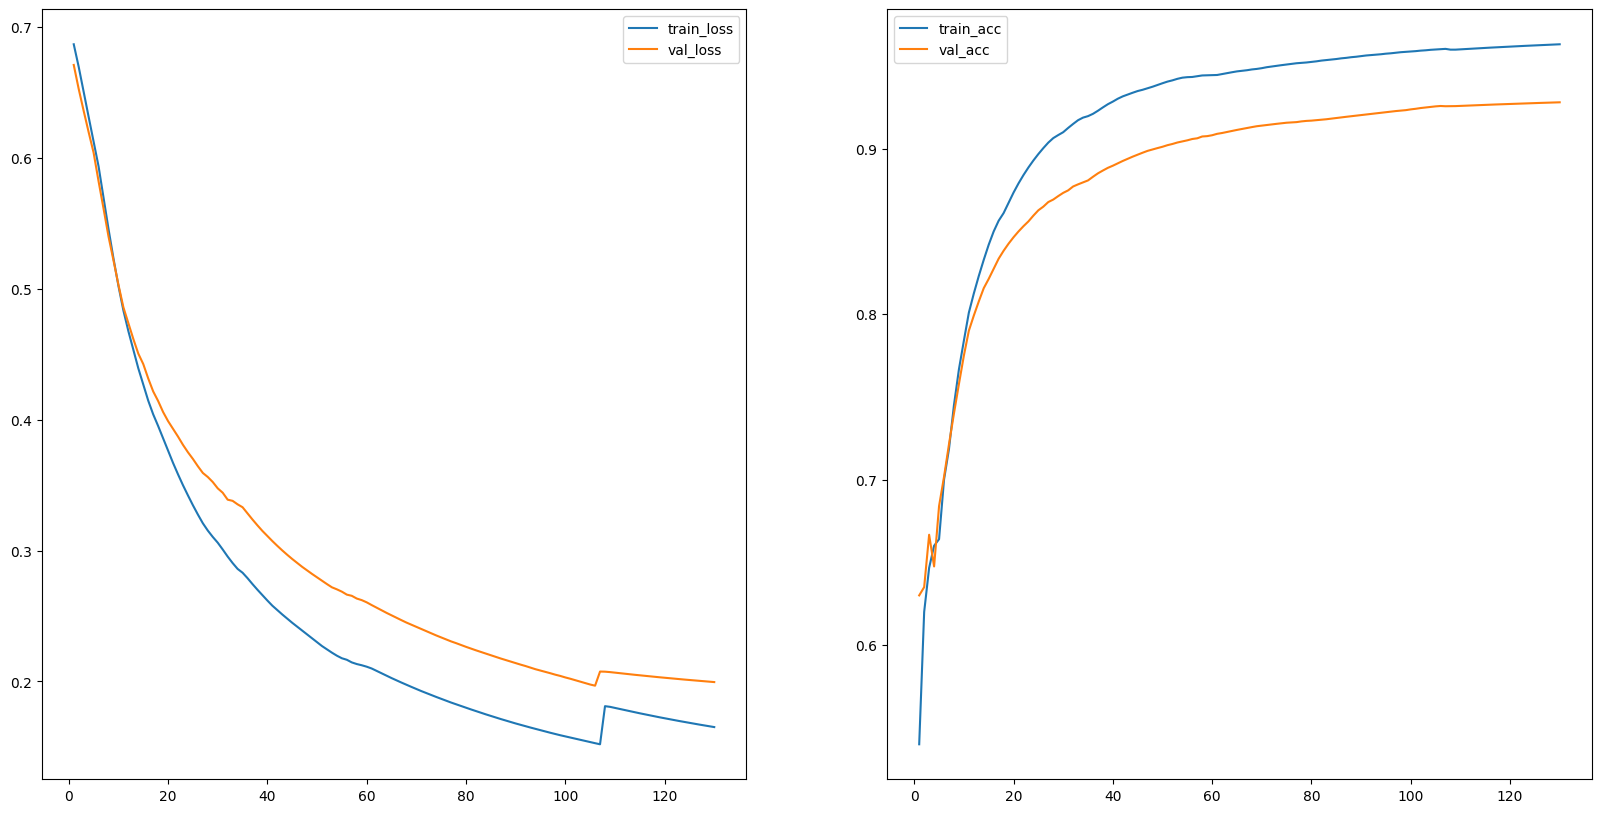

In [212]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].plot(range(1,131),tl,label='train_loss')
ax[0].plot(range(1,131),vl,label='val_loss')
ax[1].plot(range(1,131),ta,label='train_acc')
ax[1].plot(range(1,131),va,label='val_acc')
ax[0].legend()
ax[1].legend()
plt.show()

Though there's overfitting, we can see that with the training data the model is able to derive a non-linear decision boundary for the data. 

**Making model building more flexible with nn.Module:**

- In the previous example - we used pytorch's sequential class to create a fully connected NN with multiple layers. But doesn't allow us to create models with multiple inputs, outputs and intermediate branches. This is where the nn.Module comes in handy. 

- The alternative way to build complex models is by sub classing the nn.Module class. the forward() method is used to specify the forward pass. In the constructor, we define the layers as attributes of the class . In forward, we specify how these layers are to be used in the forward pass of the NN. The code for defining a new class that implements the previous model is as follows:

In [221]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2,4)
        nn.init.kaiming_normal_(l1.weight)
        a1 = nn.ReLU()
        l2 = nn.Linear(4,4)
        nn.init.kaiming_normal_(l2.weight)
        a2 = nn.ReLU()
        l3 = nn.Linear(4,4)
        nn.init.kaiming_normal_(l3.weight)
        a3 = nn.ReLU()
        l4 = nn.Linear(4,4)
        nn.init.kaiming_normal_(l4.weight)
        a4 = nn.ReLU()

        l5 = nn.Linear(4,1)
        nn.init.xavier_normal_(l5.weight)
        a5 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3, l4, a4, l5, a5]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:,0]
        return (pred >= 0.5).float()

In [ ]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): NoisyLinear()
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
# define the loss and optimizer
loss_fn = nn.BCELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=1)

In [258]:
running_train_loss = []
running_train_acc = []
validation_loss = []
validation_accuracy = []

In [259]:
tl,ta,vl,va = [],[],[],[]

In [ ]:
for epoch in range(130):
    for i, (x_tr, y_tr) in enumerate(train_dl):
        # forward pass
        outputs = model(x_tr)[:,0]
        # compute the loss
        loss = loss_fn(outputs, y_tr)
        #print(loss.item())
        # compute the gradients
        loss.backward()
        # optimize
        optimizer.step()
        running_train_loss.append(loss.item())
        
        running_train_acc.append(((outputs > 0.5).float() == y_tr).sum().item()/y_tr.shape[0])

     # set the model to evaluation mode for validation
    
    with torch.no_grad():
        for i,(x_va,y_va) in enumerate(valid_dl):
            valid_outputs = model(x_va)[:,0]
            valid_loss = loss_fn(valid_outputs,y_va)
            validation_loss.append(valid_loss.item())

            validation_accuracy.append(((valid_outputs > 0.5).float() == y_va).sum().item()/y_va.shape[0])

    optimizer.zero_grad()
    
    print(f'Epoch: {epoch+1}, train_loss: {sum(running_train_loss)/len(running_train_loss):.4f}, val_loss: {sum(validation_loss)/len(validation_loss):.4f}, train_acc: {sum(running_train_acc)/len(running_train_acc):.4f}, valid_acc: {sum(validation_accuracy)/len(validation_accuracy):.4f}')
    # validation_loss = sum(validation_loss)/len(validation_loss)
    lr_scheduler.step(sum(validation_loss)/len(validation_loss))
    tl.append(sum(running_train_loss)/len(running_train_loss))
    vl.append(sum(validation_loss)/len(validation_loss))
    ta.append(sum(running_train_acc)/len(running_train_acc))
    va.append(sum(validation_accuracy)/len(validation_accuracy))

Epoch: 1, train_loss: 1.1397, val_loss: 0.8420, train_acc: 0.4500, valid_acc: 0.4100
Epoch: 2, train_loss: 0.9636, val_loss: 0.7860, train_acc: 0.3900, valid_acc: 0.3800
Epoch: 3, train_loss: 0.8853, val_loss: 0.7580, train_acc: 0.3767, valid_acc: 0.4533
Epoch: 4, train_loss: 0.8386, val_loss: 0.7405, train_acc: 0.4375, valid_acc: 0.4925
Epoch: 5, train_loss: 0.8087, val_loss: 0.7271, train_acc: 0.4700, valid_acc: 0.5160
Epoch: 6, train_loss: 0.7843, val_loss: 0.7138, train_acc: 0.4950, valid_acc: 0.5350
Epoch: 7, train_loss: 0.7626, val_loss: 0.7016, train_acc: 0.5143, valid_acc: 0.5471
Epoch: 8, train_loss: 0.7441, val_loss: 0.6908, train_acc: 0.5325, valid_acc: 0.5563
Epoch: 9, train_loss: 0.7273, val_loss: 0.6811, train_acc: 0.5456, valid_acc: 0.5778
Epoch: 10, train_loss: 0.7121, val_loss: 0.6713, train_acc: 0.5670, valid_acc: 0.5930
Epoch: 11, train_loss: 0.6979, val_loss: 0.6624, train_acc: 0.5836, valid_acc: 0.6064
Epoch: 12, train_loss: 0.6846, val_loss: 0.6532, train_acc: 0.5

Next, beside the train history, we will use the mlxtend library to visualise the validation data and decision boundary:

In [261]:
from mlxtend.plotting import plot_decision_regions

<AxesSubplot:>

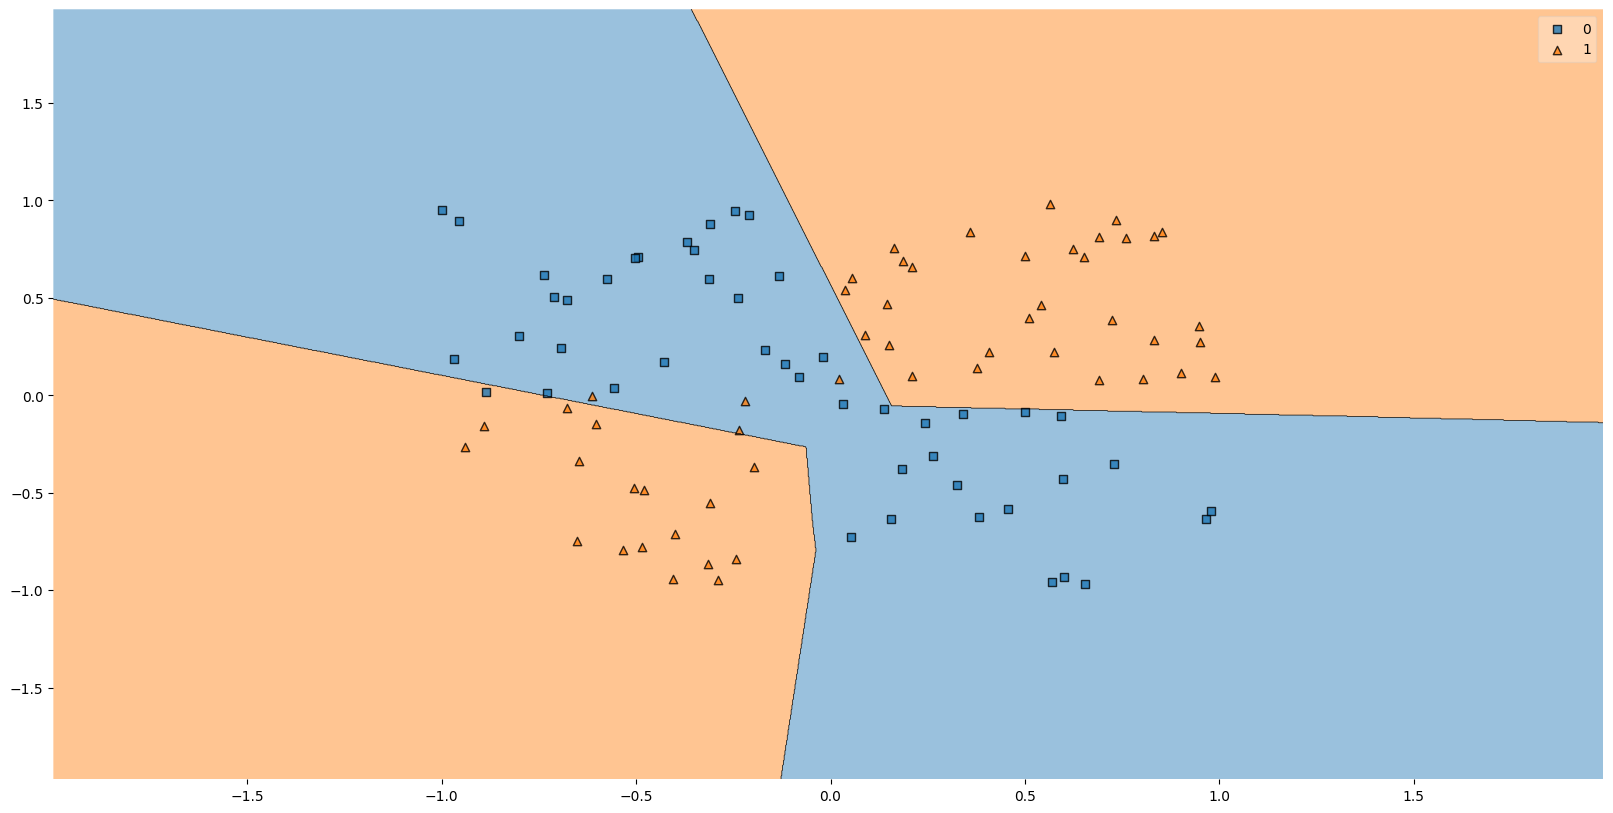

In [262]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
plot_decision_regions(X = x_valid.numpy(), y=y_valid.numpy().astype(np.int32), clf=model)

Writing custom layers in pytorch:
- In cases where we want to define a new layer that is not already supported by PyTorch, we can define a new class derived from the nn.Module class. That is especially useful when designing a new layer or customizing an existing layer.
- To illustrate the concept of implementing custom layers, consider a simple example. where we define a new layer that computes the linear regression with noise.

In [235]:
torch.Tensor(3,4)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [263]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size,output_size)
        self.w = nn.Parameter(w) # nn.Parameter is a tensor, that is a module parameter
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev
    
    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new,self.w), self.b)

Testing the layer:

In [264]:
torch.manual_seed(1)
noisy_layer = NoisyLinear(4,2)
x = torch.zeros((1,4))
print(noisy_layer(x, training=True))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)


In [265]:
print(noisy_layer(x, training=True))

tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)


In [266]:
print(noisy_layer(x, training=False))

tensor([[0., 0.]], grad_fn=<AddBackward0>)


Now, lets create a new model similar to the previous one for solving the XOR classification task. As before, we use the nn.Module class for model building, but this time, we use the NoisyLinear layer as the first hidden layer of the model. 

In [267]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = NoisyLinear(2,4)
        nn.init.kaiming_normal_(l1.w)
        a1 = nn.ReLU()
        l2 = nn.Linear(4,4)
        nn.init.kaiming_normal_(l2.weight)
        a2 = nn.ReLU()
        l3 = nn.Linear(4,4)
        nn.init.kaiming_normal_(l3.weight)
        a3 = nn.ReLU()
        l4 = nn.Linear(4,4)
        nn.init.kaiming_normal_(l4.weight)
        a4 = nn.ReLU()

        l5 = nn.Linear(4,1)
        nn.init.xavier_normal_(l5.weight)
        a5 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3, l4, a4, l5, a5]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x, training=False):
        x = self.module_list[0](x, training)
        for f in self.module_list[1:]:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:,0]
        return (pred >= 0.5).float()

In [268]:
torch.manual_seed(1)
noise_model = MyNoisyModule()
noise_model

MyNoisyModule(
  (module_list): ModuleList(
    (0): NoisyLinear()
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Linear(in_features=4, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [269]:
# define the loss and optimizer
loss_fn = nn.BCELoss()
# optimizer
optimizer = torch.optim.Adam(noise_model.parameters(),lr=0.001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=1)

In [270]:
running_train_loss = []
running_train_acc = []
validation_loss = []
validation_accuracy = []
tl,ta,vl,va = [],[],[],[]

In [271]:
for epoch in range(130):
    for i, (x_tr, y_tr) in enumerate(train_dl):
        # forward pass
        outputs = noise_model(x_tr, True)[:,0]
        # compute the loss
        loss = loss_fn(outputs, y_tr)
        #print(loss.item())
        # compute the gradients
        loss.backward()
        # optimize
        optimizer.step()
        running_train_loss.append(loss.item())
        
        running_train_acc.append(((outputs > 0.5).float() == y_tr).sum().item()/y_tr.shape[0])

     # set the model to evaluation mode for validation
    
    with torch.no_grad():
        for i,(x_va,y_va) in enumerate(valid_dl):
            valid_outputs = noise_model(x_va)[:,0]
            valid_loss = loss_fn(valid_outputs,y_va)
            validation_loss.append(valid_loss.item())

            validation_accuracy.append(((valid_outputs > 0.5).float() == y_va).sum().item()/y_va.shape[0])

    optimizer.zero_grad()
    
    print(f'Epoch: {epoch+1}, train_loss: {sum(running_train_loss)/len(running_train_loss):.4f}, val_loss: {sum(validation_loss)/len(validation_loss):.4f}, train_acc: {sum(running_train_acc)/len(running_train_acc):.4f}, valid_acc: {sum(validation_accuracy)/len(validation_accuracy):.4f}')
    # validation_loss = sum(validation_loss)/len(validation_loss)
    lr_scheduler.step(sum(validation_loss)/len(validation_loss))
    tl.append(sum(running_train_loss)/len(running_train_loss))
    vl.append(sum(validation_loss)/len(validation_loss))
    ta.append(sum(running_train_acc)/len(running_train_acc))
    va.append(sum(validation_accuracy)/len(validation_accuracy))

Epoch: 1, train_loss: 0.7070, val_loss: 0.6800, train_acc: 0.5300, valid_acc: 0.5600
Epoch: 2, train_loss: 0.6828, val_loss: 0.6571, train_acc: 0.5950, valid_acc: 0.6400
Epoch: 3, train_loss: 0.6624, val_loss: 0.6364, train_acc: 0.6233, valid_acc: 0.6733
Epoch: 4, train_loss: 0.6382, val_loss: 0.6172, train_acc: 0.6625, valid_acc: 0.6775
Epoch: 5, train_loss: 0.6140, val_loss: 0.5974, train_acc: 0.6940, valid_acc: 0.7040
Epoch: 6, train_loss: 0.5877, val_loss: 0.5879, train_acc: 0.7267, valid_acc: 0.7050
Epoch: 7, train_loss: 0.5698, val_loss: 0.5747, train_acc: 0.7400, valid_acc: 0.7200
Epoch: 8, train_loss: 0.5540, val_loss: 0.5563, train_acc: 0.7500, valid_acc: 0.7338
Epoch: 9, train_loss: 0.5348, val_loss: 0.5363, train_acc: 0.7622, valid_acc: 0.7511
Epoch: 10, train_loss: 0.5164, val_loss: 0.5175, train_acc: 0.7750, valid_acc: 0.7640
Epoch: 11, train_loss: 0.4974, val_loss: 0.5007, train_acc: 0.7864, valid_acc: 0.7745
Epoch: 12, train_loss: 0.4798, val_loss: 0.4859, train_acc: 0.7

<AxesSubplot:>

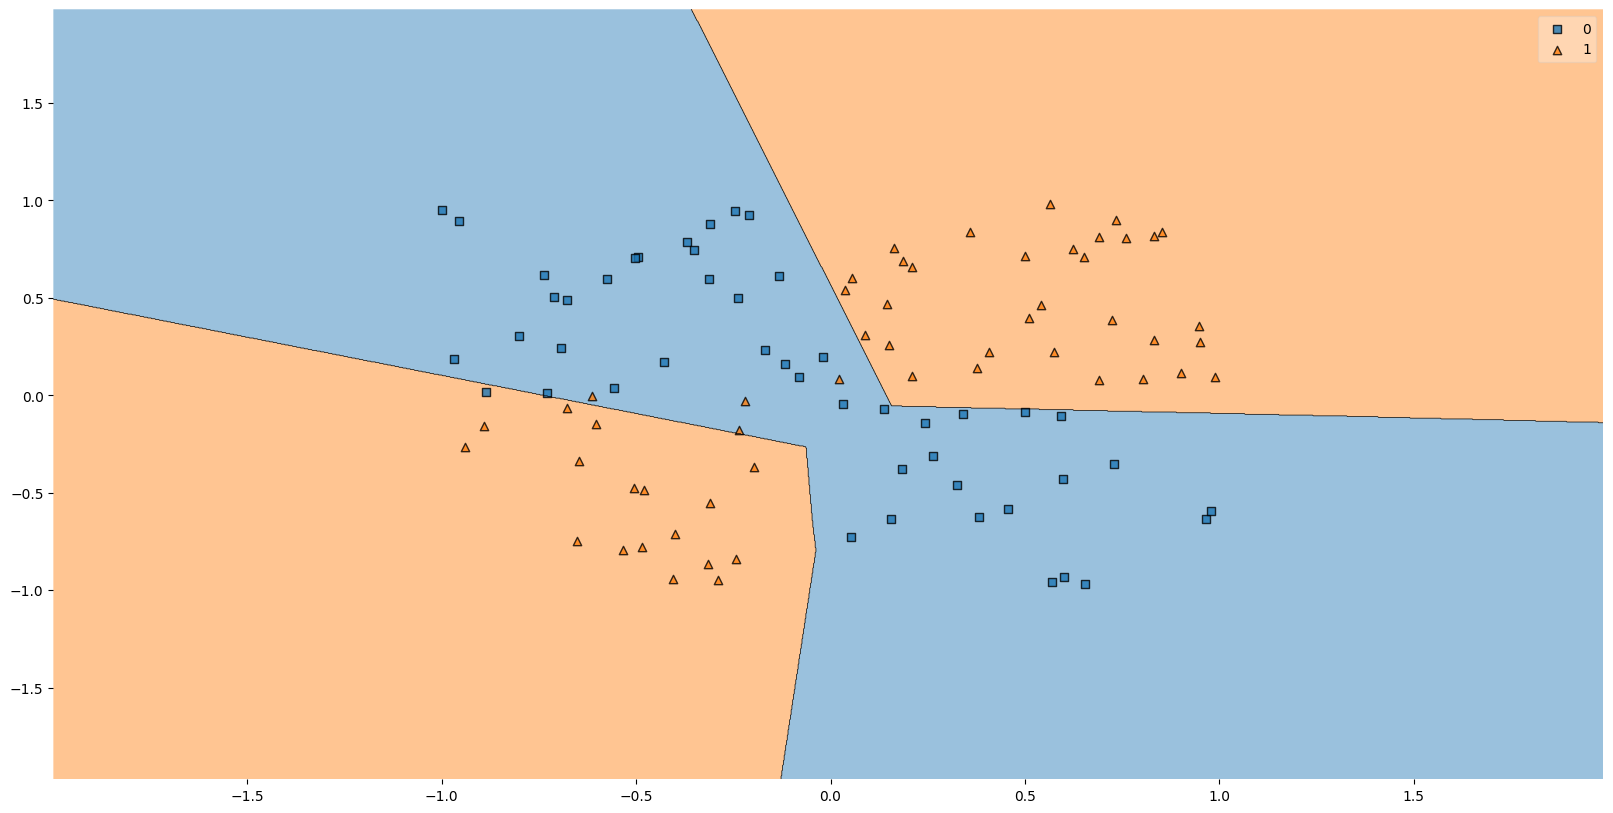

In [272]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
plot_decision_regions(X=x_valid.numpy(), y=y_valid.numpy().astype(np.int32), clf=model)